In [4]:
import os
import gc
import traceback
import numpy as np
import pandas as pd
import seaborn as sns
import datatable as dt
import gresearch_crypto
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, mean_absolute_error
data_path = '../input/g-research-crypto-forecasting/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.core.common.SettingWithCopyWarning)
    
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = [14, 8]  # width, height

In [5]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.utils.validation import _deprecate_positional_args
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples

# modified code for group gaps; source
# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class PurgedGroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Allows for a gap in groups to avoid potentially leaking info from
    train into test if the model has windowed or lag features.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_group_size : int, default=Inf
        Maximum group size for a single training set.
    group_gap : int, default=None
        Gap between train and test
    max_test_group_size : int, default=Inf
        We discard this number of groups from the end of each train split
    """

    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_group_size=np.inf,
                 max_test_group_size=np.inf,
                 group_gap=None,
                 verbose=False
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.group_gap = group_gap
        self.max_test_group_size = max_test_group_size
        self.verbose = verbose

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        group_gap = self.group_gap
        max_test_group_size = self.max_test_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))

        group_test_size = min(n_groups // n_folds, max_test_group_size)
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []

            group_st = max(0, group_test_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_test_start - group_gap)]:
                train_array_tmp = group_dict[train_group_idx]
                
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)

            train_end = train_array.size
 
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)

            test_array  = test_array[group_gap:]
            
            
            if self.verbose > 0:
                    pass
                    
            yield [int(i) for i in train_array], [int(i) for i in test_array]
            
            
            #返回的是分割成功的ID序列，训练集和测试集

In [6]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype.name
        if col_type not in ['object', 'category', 'datetime64[ns, UTC]', 'datetime64[ns]']:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [7]:
import datatable as dt
extra_data_files = {0: '../input/cryptocurrency-extra-data-binance-coin', 2: '../input/cryptocurrency-extra-data-bitcoin-cash', 1: '../input/cryptocurrency-extra-data-bitcoin', 3: '../input/cryptocurrency-extra-data-cardano', 4: '../input/cryptocurrency-extra-data-dogecoin', 5: '../input/cryptocurrency-extra-data-eos-io', 6: '../input/cryptocurrency-extra-data-ethereum', 7: '../input/cryptocurrency-extra-data-ethereum-classic', 8: '../input/cryptocurrency-extra-data-iota', 9: '../input/cryptocurrency-extra-data-litecoin', 11: '../input/cryptocurrency-extra-data-monero', 10: '../input/cryptocurrency-extra-data-maker', 12: '../input/cryptocurrency-extra-data-stellar', 13: '../input/cryptocurrency-extra-data-tron'}

# Uncomment to load the original csv [slower]
# orig_df_train = pd.read_csv(data_path + 'train.csv') 
# supp_df_train = pd.read_csv(data_path + 'supplemental_train.csv')
# df_asset_details = pd.read_csv(data_path  + 'asset_details.csv').sort_values("Asset_ID")

orig_df_train = dt.fread('../input/cryptocurrency-extra-data-binance-coin/orig_train.jay').to_pandas()
df_asset_details = dt.fread('../input/cryptocurrency-extra-data-binance-coin/orig_asset_details.jay').to_pandas()
supp_df_train = dt.fread('../input/cryptocurrency-extra-data-binance-coin/orig_supplemental_train.jay').to_pandas()
assets_details = dt.fread('../input/cryptocurrency-extra-data-binance-coin/orig_asset_details.jay').to_pandas()
asset_weight_dict = {assets_details['Asset_ID'].tolist()[idx]: assets_details['Weight'].tolist()[idx] for idx in range(len(assets_details))}
asset_name_dict = {assets_details['Asset_ID'].tolist()[idx]: assets_details['Asset_Name'].tolist()[idx] for idx in range(len(assets_details))}

def load_training_data_for_asset(asset_id, load_jay = True):
    dfs = []
    if INCCOMP: dfs.append(orig_df_train[orig_df_train["Asset_ID"] == asset_id].copy())
    if INCSUPP: dfs.append(supp_df_train[supp_df_train["Asset_ID"] == asset_id].copy())
    
    if load_jay:
        if INC2017 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2017) + '.csv'): dfs.append(dt.fread(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2017) + '.jay').to_pandas())
        if INC2018 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2018) + '.csv'): dfs.append(dt.fread(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2018) + '.jay').to_pandas())
        if INC2019 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2019) + '.csv'): dfs.append(dt.fread(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2019) + '.jay').to_pandas())
        if INC2020 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2020) + '.csv'): dfs.append(dt.fread(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2020) + '.jay').to_pandas())
        if INC2021 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2021) + '.csv'): dfs.append(dt.fread(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2021) + '.jay').to_pandas())
    else: 
        if INC2017 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2017) + '.csv'): dfs.append(pd.read_csv(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2017) + '.csv'))
        if INC2018 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2018) + '.csv'): dfs.append(pd.read_csv(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2018) + '.csv'))
        if INC2019 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2019) + '.csv'): dfs.append(pd.read_csv(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2019) + '.csv'))
        if INC2020 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2020) + '.csv'): dfs.append(pd.read_csv(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2020) + '.csv'))
        if INC2021 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2021) + '.csv'): dfs.append(pd.read_csv(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2021) + '.csv'))
    df = pd.concat(dfs, axis = 0) if len(dfs) > 1 else dfs[0]
    df['date'] = pd.to_datetime(df['timestamp'], unit = 's')
    if LOAD_STRICT: df = df.loc[df['date'] < "2021-06-13 00:00:00"]    
    df = df.sort_values('date')
    return df

def load_data_for_all_assets():
    dfs = []
    for asset_id in list(extra_data_files.keys()): dfs.append(load_training_data_for_asset(asset_id))
    return pd.concat(dfs)

In [8]:
DEVICE = 'CPU'

# CV PARAMS
FOLDS = 5
GROUP_GAP = 130
MAX_TEST_GROUP_SIZE = 180
MAX_TRAIN_GROUP_SIZE = 280

# LOAD STRICT? YES=1 NO=0 | see: https://www.kaggle.com/julian3833/proposal-for-a-meaningful-lb-strict-lgbm
LOAD_STRICT = True

# WHICH YEARS TO INCLUDE? YES=1 NO=0
INC2021 = 0
INC2020 = 0
INC2019 = 0
INC2018 = 0
INC2017 = 0
INCCOMP = 1
INCSUPP = 0

train_data = load_data_for_all_assets()
test = dt.fread('../input/cryptocurrency-extra-data-binance-coin/orig_example_test.jay').to_pandas()
sample_prediction_df = dt.fread('../input/cryptocurrency-extra-data-binance-coin/orig_example_sample_submission.jay').to_pandas()
print("Loaded all data!")

Loaded all data!


In [9]:
# Two features from the competition tutorial
def upper_shadow(df): return df['High'] - np.maximum(df['Close'], df['Open'])
def lower_shadow(df): return np.minimum(df['Close'], df['Open']) - df['Low']

# A utility function to build features from the original df
def get_features(df):
    df_feat = df[['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP']].copy()
    df_feat['upper_Shadow'] = upper_shadow(df_feat)
    df_feat['lower_Shadow'] = lower_shadow(df_feat)
    df_feat["high_div_low"] = df_feat["High"] / df_feat["Low"]
    df_feat["open_sub_close"] = df_feat["Open"] - df_feat["Close"]
    return df_feat

In [10]:
def fill_nan_inf(df):
    df = df.fillna(0)
    df = df.replace([np.inf, -np.inf], 0)
    return df

train_data['date'] = pd.to_datetime(train_data['timestamp'], unit = 's')
train_data = train_data.sort_values('date')
groups = pd.factorize(train_data['date'].dt.day.astype(str) + '_' + train_data['date'].dt.month.astype(str) + '_' + train_data['date'].dt.year.astype(str))[0]
dates = train_data['date'].copy()
train_data = train_data.drop(columns = 'date')
timestamp = train_data['timestamp'].copy()
train_data.drop(columns = 'timestamp', inplace = True)
target = train_data['Target'].copy()
train_data.drop(columns = 'Target', inplace = True)
train_data = reduce_mem_usage(train_data)
assets_idx = train_data['Asset_ID']
train_data = get_features(train_data)
train_data['Asset_ID'] = assets_idx
train_data['groups'] = groups
train_data['date'] = dates
train_data = reduce_mem_usage(train_data)
train_data['Target'] = target
train_data['Weight'] = train_data['Asset_ID'].map(asset_weight_dict)
train_data['timestamp'] = timestamp

train_data = fill_nan_inf(train_data)
test = fill_nan_inf(test)

feature_names = [i for i in train_data.columns if i not in ['Target', 'date', 'timestamp', 'VWAP', 'Asset_ID', 'groups', 'Weight']]

Memory usage of dataframe is 1525.84 MB
Memory usage after optimization is: 720.54 MB
Decreased by 52.8%
Memory usage of dataframe is 1229.15 MB
Memory usage after optimization is: 1102.00 MB
Decreased by 10.3%


<AxesSubplot:title={'center':'PurgedGroupTimeSeriesSplit'}, xlabel='Sample index', ylabel='CV iteration'>

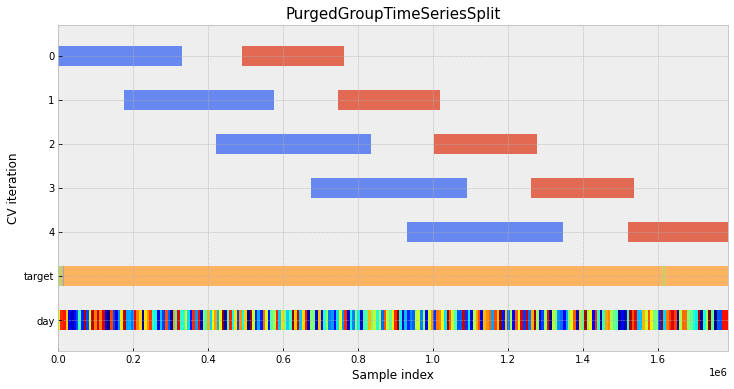

In [11]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    cmap_cv = plt.cm.coolwarm
    jet = plt.cm.get_cmap('jet', 256)
    seq = np.linspace(0, 1, 256)
    _ = np.random.shuffle(seq)   # inplace
    cmap_data = ListedColormap(jet(seq))    
    for ii, (tr, tt) in enumerate(list(cv.split(X=X, y=y, groups=group))):
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0        
        ax.scatter(range(len(indices)), [ii + .5] * len(indices), c=indices, marker='_', lw=lw, cmap=cmap_cv, vmin=-.2, vmax=1.2)
    ax.scatter(range(len(X)), [ii + 1.5] * len(X), c=y, marker='_', lw=lw, cmap=plt.cm.Set3)
    ax.scatter(range(len(X)), [ii + 2.5] * len(X), c=group, marker='_', lw=lw, cmap=cmap_data)
    yticklabels = list(range(n_splits)) + ['target', 'day']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels, xlabel='Sample index', ylabel="CV iteration", ylim=[n_splits+2.2, -.2], xlim=[0, len(y)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

def plot_importance(importances, features_names, PLOT_TOP_N = 20, figsize=(12, 20)):
    try: plt.close()
    except: pass
    importance_df = pd.DataFrame(data=importances, columns=features_names)
    sorted_indices = importance_df.median(axis=0).sort_values(ascending=False).index
    sorted_importance_df = importance_df.loc[:, sorted_indices]
    plot_cols = sorted_importance_df.columns[:PLOT_TOP_N]
    _, ax = plt.subplots(figsize=figsize)
    ax.grid()
    ax.set_xscale('log')
    ax.set_ylabel('Feature')
    ax.set_xlabel('Importance')
    plt.title('Feature Importances')
    sns.boxplot(data=sorted_importance_df[plot_cols], orient='h', ax=ax)
    plt.show()
    
asset_id = 0
df = load_training_data_for_asset(asset_id)
df_proc = get_features(df)
df_proc['date'] = df['date'].copy()
df_proc['y'] = df['Target']
df_proc = df_proc.dropna(how="any")
X_temp = df_proc.drop("y", axis=1)
y_temp = df_proc["y"]
groups_temp = pd.factorize(X_temp['date'].dt.day.astype(str) + '_' + X_temp['date'].dt.month.astype(str) + '_' + X_temp['date'].dt.year.astype(str))[0]
X_temp = X_temp.drop(columns = 'date')

fig, ax = plt.subplots(figsize = (12, 6))
cv = PurgedGroupTimeSeriesSplit(n_splits = FOLDS, group_gap = GROUP_GAP, max_train_group_size=MAX_TRAIN_GROUP_SIZE, max_test_group_size=MAX_TEST_GROUP_SIZE)
plot_cv_indices(cv, X_temp, y_temp, groups_temp, ax, FOLDS, lw=20)

In [12]:
y = train_data['Target'].values
X = train_data[feature_names].values
groups = train_data['groups'].values
weights = train_data['Weight'].values

In [13]:
SEED = 42
FOLDS = 5
TRAINING = True
AE_EPOCHS = 1
BATCH_SIZE = 2048
SAVE_WEIGHTS = True
USE_FINETUNE = True
SEARCH_EPOCHS = 1

In [14]:
import gc
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from random import choices
from scipy.stats import pearsonr
import pandas as pd, numpy as np
from sklearn.metrics import r2_score
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import GroupKFold
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Concatenate, Lambda, GaussianNoise, Activation

import kerastuner as kt

def set_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

class CVTuner(kt.engine.tuner.Tuner):
    def run_trial(self, trial, X, y, splits, batch_size = 32, epochs = 1, callbacks = None):
        val_losses = []
        for train_indices, test_indices in splits:
            X_train, X_test = [x[train_indices] for x in X], [x[test_indices] for x in X]
            y_train, y_test = [a[train_indices] for a in y], [a[test_indices] for a in y]
            if len(X_train) < 2:
                X_train = X_train[0]
                X_test = X_test[0]
            if len(y_train) < 2:
                y_train = y_train[0]
                y_test = y_test[0]
            model = self.hypermodel.build(trial.hyperparameters)
            hist = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = epochs, batch_size = batch_size, callbacks = callbacks)
            val_losses.append([hist.history[k][-1] for k in hist.history])
        val_losses = np.asarray(val_losses)
        self.oracle.update_trial(trial.trial_id, {k: np.mean(val_losses[:, i]) for i, k in enumerate(hist.history.keys())})
        self.save_model(trial.trial_id, model)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.


In [15]:
def create_autoencoder(input_dim, output_dim, noise = 0.05):
    i = Input(input_dim)
    encoded = BatchNormalization()(i)
    encoded = GaussianNoise(noise)(encoded)
    encoded = Dense(64, activation = 'relu')(encoded)
    decoded = Dropout(0.2)(encoded)
    decoded = Dense(input_dim, name = 'decoded')(decoded)
    x = Dense(32, activation = 'relu')(decoded)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(output_dim, activation = 'linear', name = 'label_output')(x)
    encoder = Model(inputs = i, outputs = decoded)
    autoencoder = Model(inputs = i, outputs = [decoded, x])
    encoder.summary()
    autoencoder.summary()
    autoencoder.compile(optimizer = Adam(0.001), loss = {'decoded': 'mse', 'label_output': 'mse'})
    return autoencoder, encoder

In [16]:
def create_model(hp, input_dim, output_dim, encoder, weights = None):
    inputs = Input(input_dim)
    x = encoder(inputs)
    x = Concatenate()([x, inputs])  # use both raw and encoded features
    x = BatchNormalization()(x)
    x = Dropout(hp.Float('init_dropout', 0.0, 0.5))(x)
    for i in range(hp.Int('num_layers', 1, 3)):
        x = Dense(hp.Int('num_units_{i}', 64, 128))(x)
        x = BatchNormalization()(x)
        x = Lambda(tf.keras.activations.swish)(x)
        x = Dropout(hp.Float(f'dropout_{i}', 0.0, 0.5))(x)
    x = Dense(output_dim, activation = 'linear')(x)
    model = Model(inputs = inputs, outputs = x)
    model.compile(optimizer = Adam(hp.Float('lr', 0.00001, 0.1, default = 0.001)), loss = 'mse', metrics = [nn_comp_metric(weights)] if weights is not None else [])
    return model

In [17]:
autoencoder, encoder = create_autoencoder(X.shape[-1], 1, noise=0.1)
set_all_seeds(42)
if TRAINING:
    autoencoder.fit(X, (X, y), epochs=AE_EPOCHS, batch_size=BATCH_SIZE, validation_split=0.1, callbacks=[EarlyStopping('val_loss',patience=10,restore_best_weights=True)])
    if SAVE_WEIGHTS: encoder.save_weights('./encoder.hdf5')
else: encoder.load_weights('../input/v7seedencoderdecoder2223/encoder.hdf5')
encoder.trainable = False


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 10)                40        
_________________________________________________________________
gaussian_noise (GaussianNois (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                704       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
decoded (Dense)              (None, 10)                650       
Total params: 1,394
Trainable params: 1,374
Non-trainable params: 20
__________________________________________________________

2021-11-25 18:27:50.209332: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


9766/9766 [==============================] - 94s 9ms/step - loss: 486619742208.0000 - decoded_loss: 486619742208.0000 - label_output_loss: 0.0136 - val_loss: 1687641784320.0000 - val_decoded_loss: 1687641784320.0000 - val_label_output_loss: 6.9522e-05


In [18]:
model_fn = lambda hp: create_model(hp, X.shape[-1], 1, encoder)
model_fn_weights = lambda hp, weights: create_model(hp, X.shape[-1], 1, encoder, weights)

tuner = CVTuner(
        hypermodel=model_fn,
        oracle=kt.oracles.BayesianOptimization(
        objective= kt.Objective('val_loss', direction='min'),
        num_initial_points=4,
        max_trials=20))

In [19]:
# Numpy Version
def corr(a, b, w):
    cov = lambda x, y: np.sum(w * (x - np.average(x, weights=w)) * (y - np.average(y, weights=w))) / np.sum(w)
    return cov(a, b) / np.sqrt(cov(a, a) * cov(b, b))

# TF Version
def tf_cov(x, y, w): return (tf.reduce_sum(w * (x - tf.reduce_mean(x * w)) * (y - tf.reduce_mean(y * w))) / tf.reduce_sum(w))
def tf_comp_metric(a, b, w): return tf_cov(a, b, w) / tf.sqrt(tf_cov(a, a, w) * tf_cov(b, b, w))
def nn_comp_metric(w): 
    def wcorr(x, y): return tf_comp_metric(tf.cast(x, tf.float32), tf.cast(y, tf.float32), tf.cast(w, tf.float32))
    return wcorr

Trial 20 Complete [00h 06m 31s]
val_loss: 5.101423666928895e-05

Best val_loss So Far: 2.891571639338508e-05
Total elapsed time: 01h 17m 49s
1588/1588 [==============================] - 21s 13ms/step - loss: 0.0069 - val_loss: 2.8386e-05
Epoch 1/3
1557/1557 [==============================] - 17s 10ms/step - loss: 2.8737e-05
Epoch 2/3
1557/1557 [==============================] - 16s 10ms/step - loss: 2.8591e-05
Epoch 3/3
2271/2271 [==============================] - 29s 12ms/step - loss: 0.0065 - val_loss: 2.9635e-05
Epoch 1/3
1560/1560 [==============================] - 17s 10ms/step - loss: 1.8623e-05
Epoch 2/3
1560/1560 [==============================] - 16s 10ms/step - loss: 1.8526e-05
Epoch 3/3
2420/2420 [==============================] - 31s 12ms/step - loss: 0.0197 - val_loss: 1.8968e-05
Epoch 1/3
1586/1586 [==============================] - 17s 10ms/step - loss: 1.7260e-05
Epoch 2/3
1586/1586 [==============================] - 17s 10ms/step - loss: 1.7122e-05
Epoch 3/3
2457/2457 

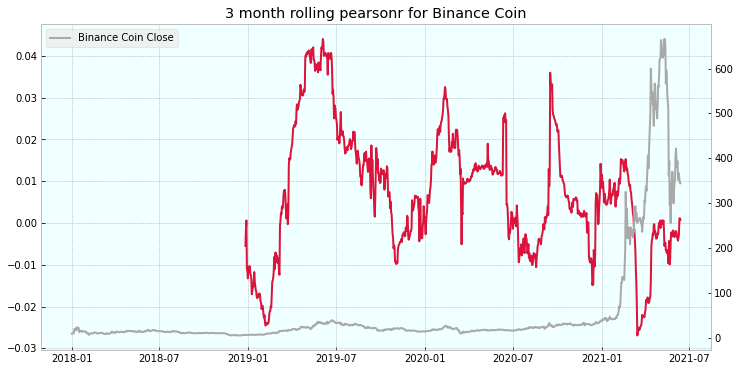



--------------------------------------------------------------------------------
Finished training EOS.IO. Results:
Model: r2_score: -0.005704899180325018 | pearsonr: -0.001975495604687079 | wcorr: -0.001975495604687075 
Predictions std: 0.00034384098673426053 | Target std: 0.00494493082502521


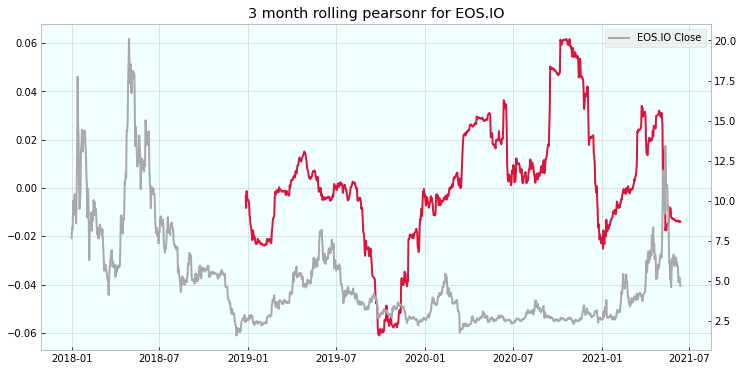



--------------------------------------------------------------------------------
Finished training Monero. Results:
Model: r2_score: -0.0038718051298927136 | pearsonr: -0.0019271656530551987 | wcorr: -0.0019271656530551805 
Predictions std: 0.00036442494811426187 | Target std: 0.00633161487502712


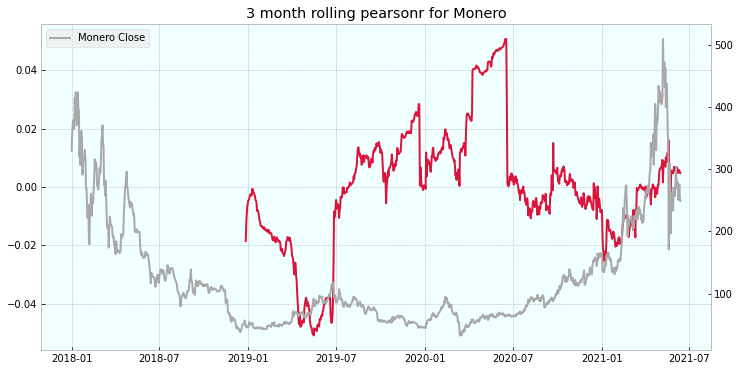



--------------------------------------------------------------------------------
Finished training Ethereum. Results:
Model: r2_score: -0.010873959451743742 | pearsonr: -0.0006368217518277113 | wcorr: -0.0006368217518277156 
Predictions std: 0.0002593209648466251 | Target std: 0.002542099215310343


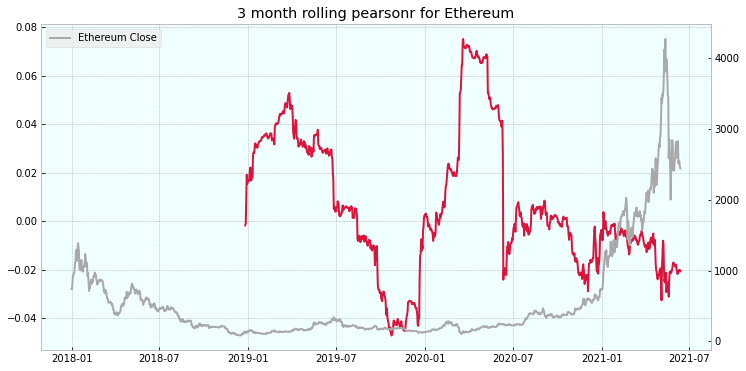



--------------------------------------------------------------------------------
Finished training Ethereum Classic. Results:
Model: r2_score: -0.0014445444091000237 | pearsonr: 0.0002826935780283666 | wcorr: 0.00028269357802836225 
Predictions std: 0.000345513888743597 | Target std: 0.009254690541410452


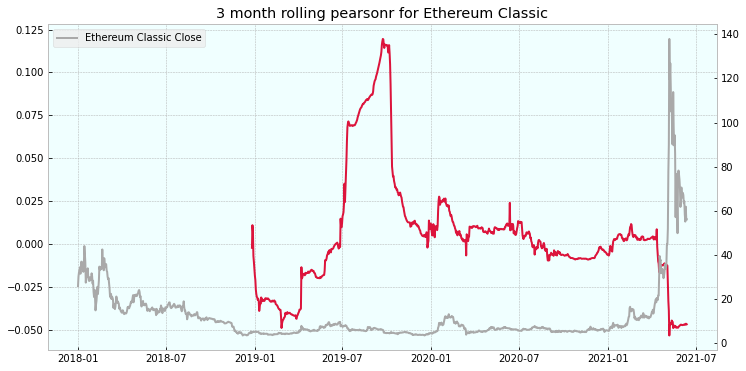



--------------------------------------------------------------------------------
Finished training Litecoin. Results:
Model: r2_score: -0.010155714581237651 | pearsonr: -0.002705812843462538 | wcorr: -0.0027058128434625317 
Predictions std: 0.00033111630813824003 | Target std: 0.003591519223735473


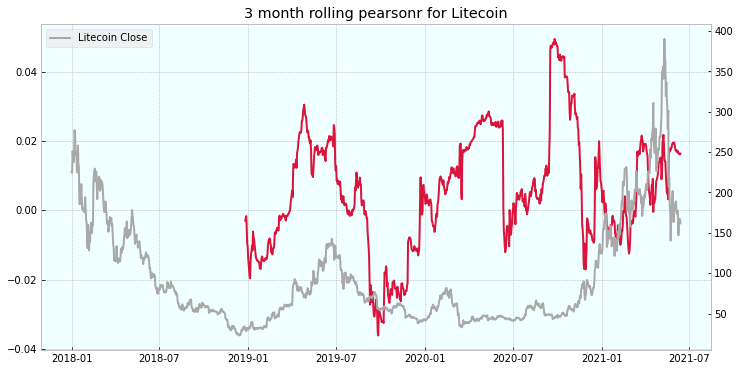



--------------------------------------------------------------------------------
Finished training Bitcoin Cash. Results:
Model: r2_score: -0.0026702887645100315 | pearsonr: -0.0007177140366097605 | wcorr: -0.0007177140366097612 
Predictions std: 0.00032693878402612054 | Target std: 0.006694166208082861


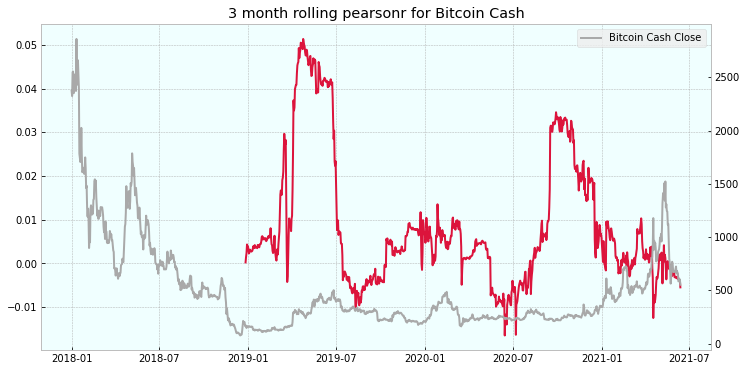



--------------------------------------------------------------------------------
Finished training Bitcoin. Results:
Model: r2_score: -0.04908935228262212 | pearsonr: -0.010684174337427915 | wcorr: -0.010684174337427904 
Predictions std: 0.00042273508832565027 | Target std: 0.002043465367662073


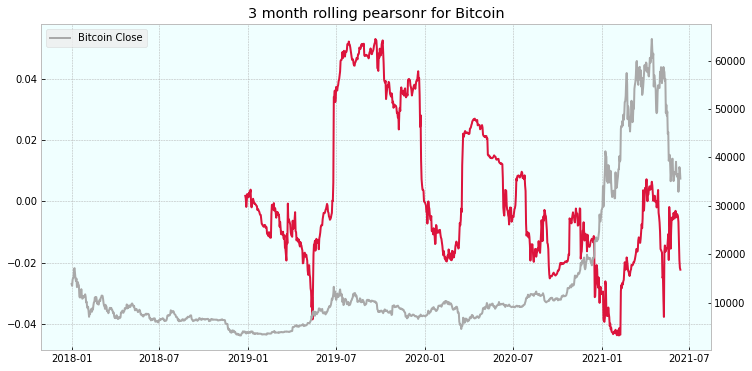



--------------------------------------------------------------------------------
Finished training TRON. Results:
Model: r2_score: -0.0049379512984562 | pearsonr: 0.0004723889542745239 | wcorr: 0.0004723889542745278 
Predictions std: 0.00033514077751833514 | Target std: 0.005027229997011936


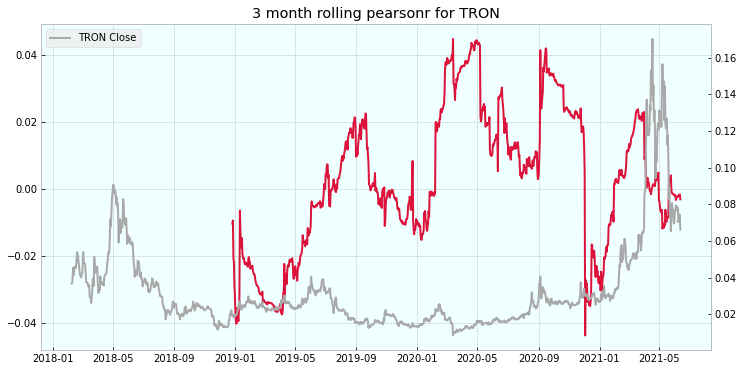



--------------------------------------------------------------------------------
Finished training Stellar. Results:
Model: r2_score: -0.005442010553401433 | pearsonr: -0.0012436597767032105 | wcorr: -0.001243659776703197 
Predictions std: 0.0003575425648716466 | Target std: 0.005264874907634628


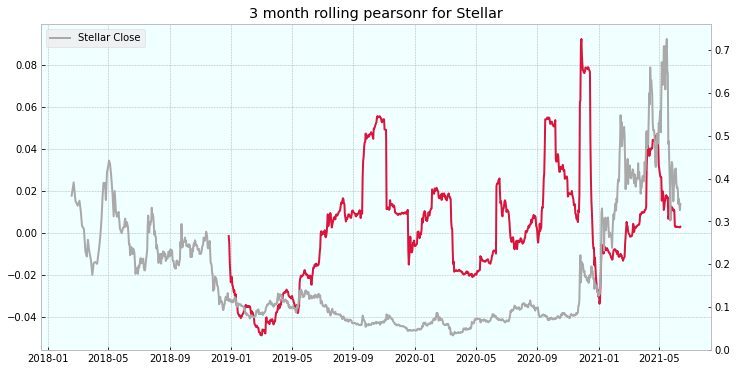



--------------------------------------------------------------------------------
Finished training Cardano. Results:
Model: r2_score: -0.005936502849568592 | pearsonr: 0.0048734566765073 | wcorr: 0.0048734566765073 
Predictions std: 0.00035467771513053895 | Target std: 0.004592266495116166


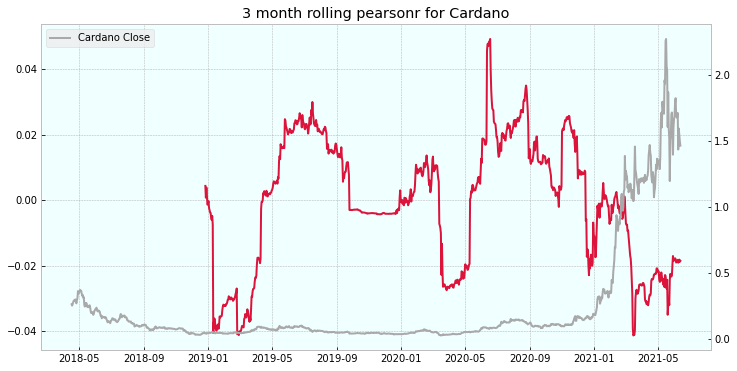



--------------------------------------------------------------------------------
Finished training IOTA. Results:
Model: r2_score: -0.0028915392436359433 | pearsonr: 0.003912222212284948 | wcorr: 0.003912222212284955 
Predictions std: 0.00037913869738442923 | Target std: 0.00699462328939879


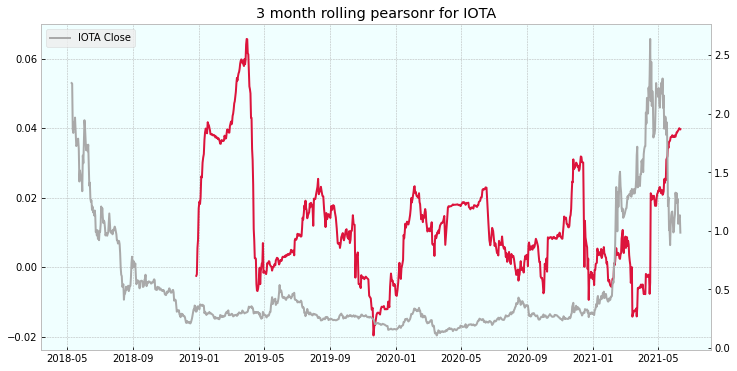



--------------------------------------------------------------------------------
Finished training Maker. Results:
Model: r2_score: -0.0031386710133756157 | pearsonr: 0.009624417397644094 | wcorr: 0.009624417397644091 
Predictions std: 0.0003945530431440567 | Target std: 0.005966691452771564


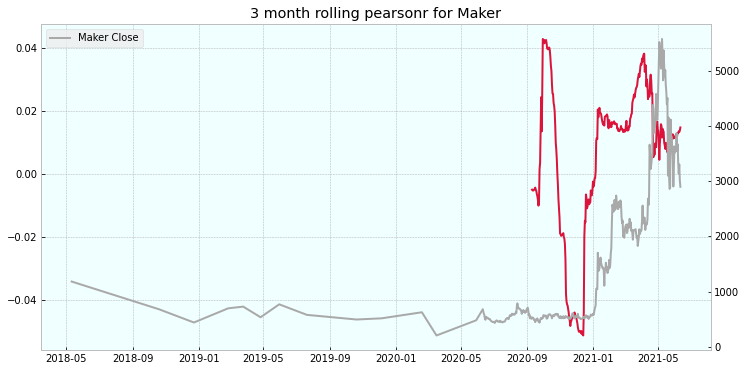



--------------------------------------------------------------------------------
Finished training Dogecoin. Results:
Model: r2_score: -0.007780245433320454 | pearsonr: -0.029132578004334934 | wcorr: -0.029132578004335004 
Predictions std: 0.0005074791958497927 | Target std: 0.007992163440899341


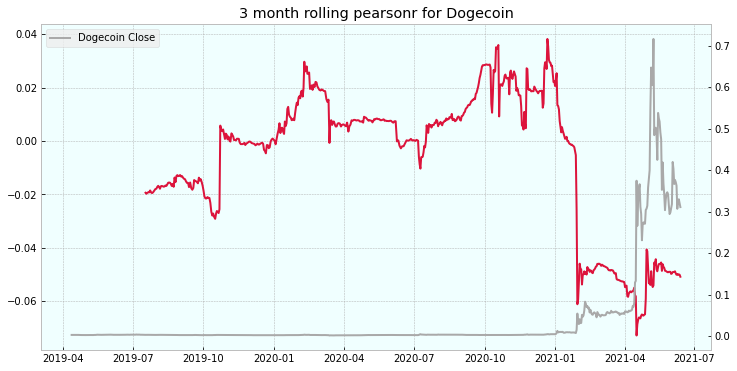

In [20]:
if TRAINING:    
    models = []    
    gkf = PurgedGroupTimeSeriesSplit(n_splits = FOLDS,
    group_gap = GROUP_GAP,
    max_train_group_size = MAX_TRAIN_GROUP_SIZE,
    max_test_group_size = MAX_TEST_GROUP_SIZE
    )
    splits = list(gkf.split(y, groups=groups))
    tuner.search((X,),(y,),splits=splits,batch_size=BATCH_SIZE,epochs=SEARCH_EPOCHS,callbacks=[EarlyStopping('val_loss', mode='min',patience=3)])
    hp  = tuner.get_best_hyperparameters(1)[0]
    pd.to_pickle(hp,f'./best_hp_{SEED}.pkl')
    oof = np.zeros(len(X))
    for fold, (train_indices, test_indices) in enumerate(splits):
        model = model_fn(hp)
        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]
        model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=SEARCH_EPOCHS,batch_size=BATCH_SIZE,callbacks=[EarlyStopping('val_loss',mode='min',patience=10,restore_best_weights=True)])
        if SAVE_WEIGHTS: model.save_weights(f'./model_{SEED}_{fold}.hdf5')
        model.compile(Adam(hp.get('lr')/100),loss='mse')
        model.fit(X_test,y_test,epochs=3,batch_size=BATCH_SIZE)
        oof[test_indices] = model.predict(X_test)[:, 0]
        if SAVE_WEIGHTS: model.save_weights(f'./model_{SEED}_{fold}_finetune.hdf5')
        gc.collect()
        models.append(model)
    tuner.results_summary()
    pd.DataFrame({'timestamp': train_data['timestamp'], 'asset_id': train_data['Asset_ID'], 'oof_preds': oof}).to_csv('oof.csv', index = False)
    
    for asset in train_data['Asset_ID'].unique().tolist():       
        df = train_data.loc[train_data['Asset_ID'] == asset]
        df['oof_preds'] = np.nan_to_num(oof[train_data['Asset_ID'] == asset])
        df['Target'] = np.nan_to_num(df['Target'])
        df['y'] = np.nan_to_num(df['Target'])

        print('\n\n' + ('-' * 80) + '\n' + 'Finished training %s. Results:' % asset_name_dict[asset])
        print('Model: r2_score: %s | pearsonr: %s | wcorr: %s ' % (r2_score(df['y'], df['oof_preds']), pearsonr(df['y'], df['oof_preds'])[0], corr(df['y'].values, df['oof_preds'].values, np.array([asset_weight_dict[asset_id]] * len(df['y'].values)))))
        print('Predictions std: %s | Target std: %s' % (df['oof_preds'].std(), df['y'].std()))

        try: plt.close()
        except: pass   
        df2 = df.reset_index().set_index('date')
        fig = plt.figure(figsize = (12, 6))
        # fig, ax_left = plt.subplots(figsize = (12, 6))
        ax_left = fig.add_subplot(111)
        ax_left.set_facecolor('azure')    
        ax_right = ax_left.twinx()
        ax_left.plot(df2['y'].rolling(3 * 30 * 24 * 60).corr(df2['oof_preds']).iloc[::24 * 60], color = 'crimson', label = "Target WCorr")
        ax_right.plot(df2['Close'].iloc[::24 * 60], color = 'darkgrey', label = "%s Close" % asset_name_dict[asset])   
        plt.legend()
        plt.grid()
        plt.xlabel('Time')
        plt.title('3 month rolling pearsonr for %s' % (asset_name_dict[asset]))
        plt.show()
    
else:
    models = []
    hp = pd.read_pickle(f'../input/v7seedencoderdecoder2223/best_hp_{SEED}.pkl')
    for f in range(FOLDS):
        model = model_fn(hp)
        if USE_FINETUNE: model.load_weights(f'../input/v7seedencoderdecoder2223/model_{SEED}_{f}_finetune.hdf5')
        else: model.load_weights(f'../input/v7seedencoderdecoder2223/model_{SEED}_{f}.hdf5')
        models.append(model)

# <span class="title-section w3-xxlarge" id="submit">Submit To Kaggle 🇰</span>
<hr>

In [21]:
env = gresearch_crypto.make_env()
iter_test = env.iter_test()

In [22]:
all_df_test = []
for i, (df_test, df_pred) in enumerate(iter_test):
    for j , row in df_test.iterrows():
        try:            
            x_test = get_features(row)
            x_test = fill_nan_inf(x_test)
            y_pred = np.mean(np.concatenate([np.expand_dims(model.predict(x_test[feature_names].to_frame().T.values), axis = 0) for model in models], axis = 0), axis = 0)
        except: 
            y_pred = 0.0
            traceback.print_exc()
        df_pred.loc[df_pred['row_id'] == row['row_id'], 'Target'] = y_pred
    all_df_test.append(df_test)
    env.predict(df_pred)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
